Limpiar y transformar los datos crudos descargados desde la API de binance para que todas las bars (time, tick, volume, dollar) parten de una fuetne coherente y estandarizada

In [59]:
# imports 
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt

In [60]:
# load csv from /raw and clean it to /processed 

data = pd.read_csv('../data/raw/BTCUSDT_1m_2024-12-01_to_2025-01-01.csv')

if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')

data.head()



,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore
0,2024-12-01 05:00:00,96515.51,96515.51,96473.18,96473.18,8.03059,2024-12-01 05:00:59.999,7.749735e+05,1842,2.96502,286150.354490,0
1,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044,0.82286,79377.044051,0
2,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030,9.65762,931709.380920,0
3,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520,0.81025,78177.723577,0
4,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603,0.10671,10295.342507,0


In [61]:
print(len(data))
# ensure the columns are numeric and times in datetime format

# helper function to convert to datetime with error handling if the unit is not in milliseconds
def safe_to_datetime(series):
    try:
        return pd.to_datetime(series, unit='ms')
    except (ValueError, TypeError):
        return pd.to_datetime(series, errors='coerce')

data['open_time'] = safe_to_datetime(data['open_time'])
data['close_time'] = safe_to_datetime(data['close_time'])
data['open'] = pd.to_numeric(data['open'])
data['high'] = pd.to_numeric(data['high'])
data['low'] = pd.to_numeric(data['low'])
data['close'] = pd.to_numeric(data['close'])
data['volume'] = pd.to_numeric(data['volume'])
data['quote_volume'] = pd.to_numeric(data['quote_volume'])
data['trades'] = pd.to_numeric(data['trades'])

data.head()

44641


,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore
0,2024-12-01 05:00:00,96515.51,96515.51,96473.18,96473.18,8.03059,2024-12-01 05:00:59.999,7.749735e+05,1842,2.96502,286150.354490,0
1,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044,0.82286,79377.044051,0
2,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030,9.65762,931709.380920,0
3,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520,0.81025,78177.723577,0
4,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603,0.10671,10295.342507,0


In [62]:
# drop duplicates
data = data.drop_duplicates()
# drop nulls 
data = data.dropna()

# sort by open_time avoid misalignments
data = data.sort_values(by='open_time').reset_index(drop=True)
print(len(data))

# delete duplicated times 
data = data.drop_duplicates(subset=['open_time'])
print("data length after dropping duplicated times: ", len(data))

# check for missing minutes
data['time_diff'] = data['open_time'].diff().dt.total_seconds().div(60) # get data and 
missing_minutes = data[data['time_diff'] > 1]
print(missing_minutes.head())

44641
data length after dropping duplicated times:  44641
Empty DataFrame
Columns: [open_time, open, high, low, close, volume, close_time, quote_volume, trades, taker_buy_base, taker_buy_quote, ignore, time_diff]
Index: []


In [63]:
# derivated data from the the columns 

data['mid_price'] = (data['high'] + data['low']) / 2
data['return'] = data['close'].pct_change()

In [64]:
# delete NaNs or infinities
len_data = len(data)
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("data length after dropping NaNs and infinities: ", len_data - len(data))

data length after dropping NaNs and infinities:  1


data length before dropping outliers:  44640


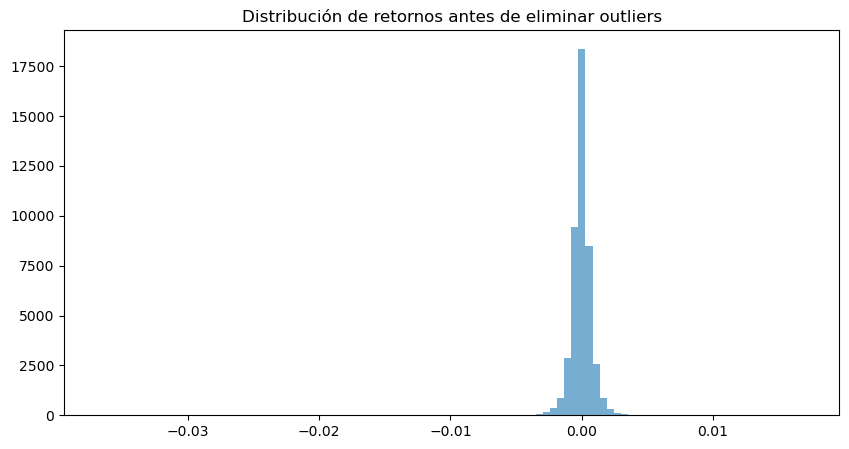

data length after dropping outliers estabdar:  609
data length after dropping outliers robust:  1326


In [65]:
# see the distribution of returns after removing outliers
print("data length before dropping outliers: ", len(data))
plt.figure(figsize=(10,5))
plt.hist(data['return'], bins=100, alpha=0.6)
plt.title("Distribución de retornos antes de eliminar outliers")
plt.show()

# delete extreme outliers using z-score alternative method

alternative_data = data.copy()
alternative_len = len(alternative_data)
alternative_data['z_score'] = (alternative_data['return'] - alternative_data['return'].mean()) / alternative_data['return'].std()
alternative_data = alternative_data[(alternative_data['z_score'] < 3) & (alternative_data['z_score'] > -3)]
print("data length after dropping outliers estabdar: ", alternative_len - len(alternative_data))

# use more robust method using (median and MAD)
median = data['return'].median()
mad = np.median(np.abs(data['return'] - median))

# calculate z-score more robust (based in MAD) 
data['z-score'] = 0.6745 * (data['return'] - median) / mad

# delete extreme outliers (|z| > 3.5)
data = data[np.abs(data['z-score']) < 3.5]
print("data length after dropping outliers robust: ", len_data - len(data))

# delete auxiliary columns
data = data.drop(columns=['time_diff', 'z-score'])
alternative_data = alternative_data.drop(columns=['time_diff', 'z_score'])

data length before dropping outliers:  44640


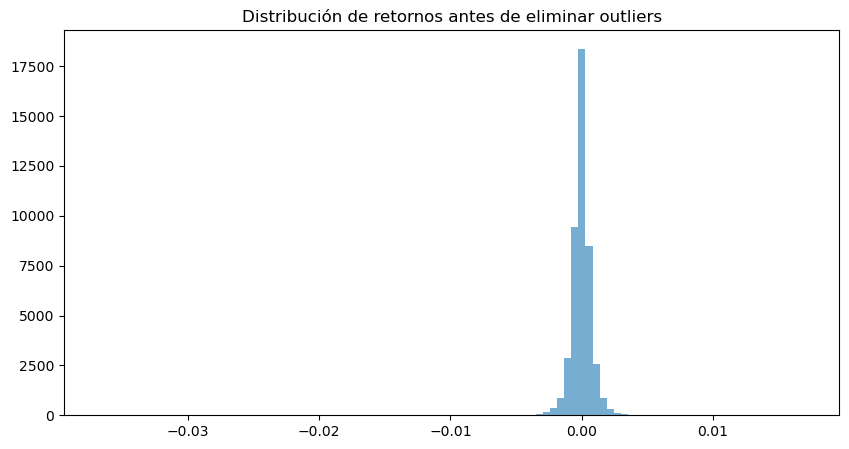

data length after dropping outliers estabdar:  609
data length after dropping outliers robust:  1326


In [ ]:
# see the distribution of returns after removing outliers
print("data length before dropping outliers: ", len(data))
plt.figure(figsize=(10,5))
plt.hist(data['return'], bins=100, alpha=0.6)
plt.title("Distribución de retornos antes de eliminar outliers")
plt.show()

# delete extreme outliers using z-score alternative method

alternative_data = data.copy()
alternative_len = len(alternative_data)
alternative_data['z_score'] = (alternative_data['return'] - alternative_data['return'].mean()) / alternative_data['return'].std()
alternative_data = alternative_data[(alternative_data['z_score'] < 3) & (alternative_data['z_score'] > -3)]
print("data length after dropping outliers estabdar: ", alternative_len - len(alternative_data))

# use more robust method using (median and MAD)
median = data['return'].median()
mad = np.median(np.abs(data['return'] - median))

# calculate z-score more robust (based in MAD) 
data['z-score'] = 0.6745 * (data['return'] - median) / mad

# delete extreme outliers (|z| > 3.5)
data = data[np.abs(data['z-score']) < 3.5]
print("data length after dropping outliers robust: ", len_data - len(data))

# delete auxiliary columns
data = data.drop(columns=['time_diff', 'z-score'])
alternative_data = alternative_data.drop(columns=['time_diff', 'z_score'])

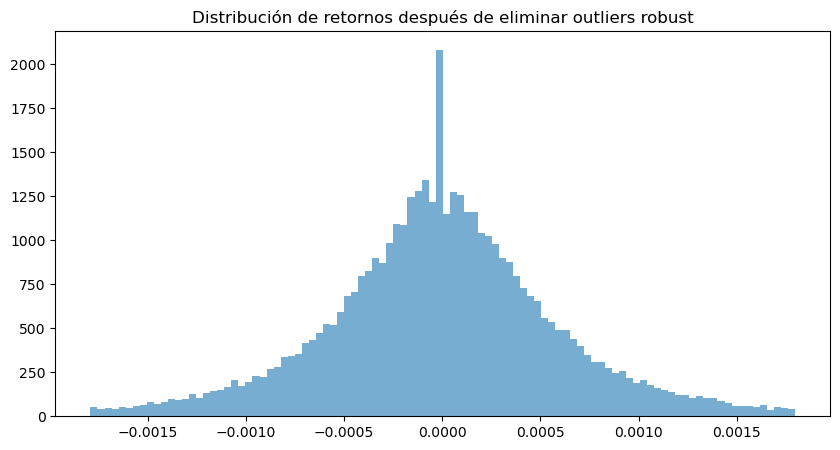

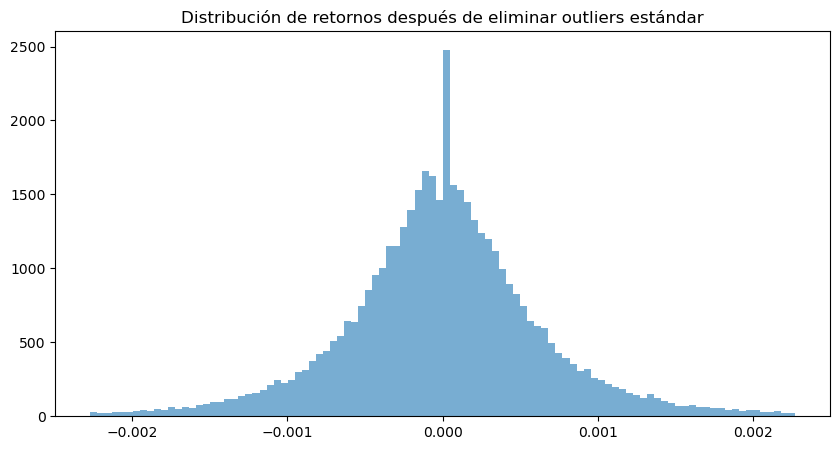

In [66]:


# see distribution using more robust method
plt.figure(figsize=(10,5))
plt.hist(data['return'], bins=100, alpha=0.6)
plt.title("Distribución de retornos después de eliminar outliers robust")
plt.show()

# see the distribution of returns

plt.figure(figsize=(10,5))
plt.hist(alternative_data['return'], bins=100, alpha=0.6)
plt.title("Distribución de retornos después de eliminar outliers estándar")
plt.show()

In [67]:
# save robust data in csv /processed 
data.to_csv('../data/processed/BTCUSDT_1m_2024-12-01_to_2025-01-01_cleaned_robust.csv', index=False)